In [2]:
from collections import defaultdict
from itertools import chain
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import seaborn as sns
from sklearn.mixture import GaussianMixture
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains"
mean_dist_dict = defaultdict(list)
std_dist_dict = defaultdict(list)

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        mean_dist_dict[int(force * 10)].append(dists_df.max_dist.mean())
        std_dist_dict[int(force * 10)].append(dists_df.max_dist.std())

Text(0,0.5,'Mean maximum distance')

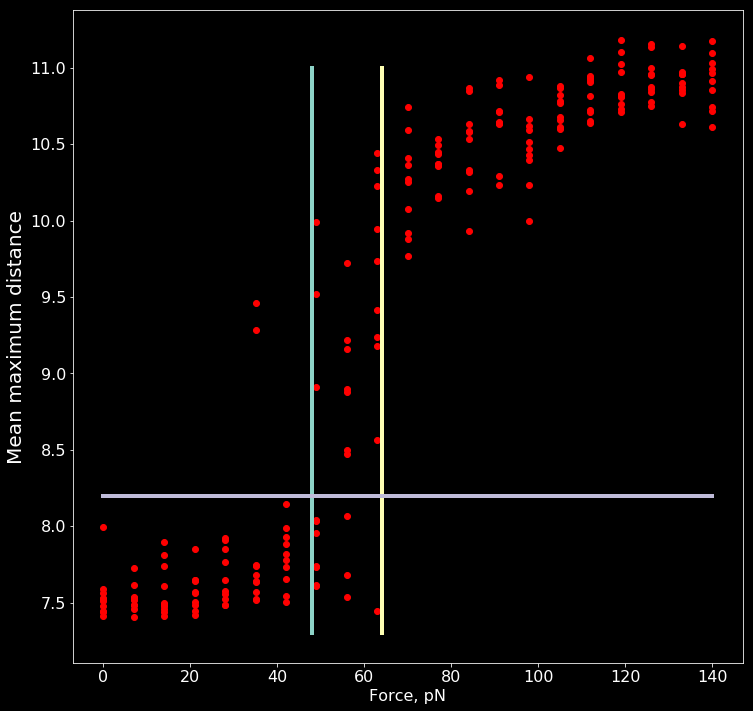

In [3]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in mean_dist_dict.items():
    ax.plot([k * 7] * len(v), v, "ro")
    
ax.plot([48, 48], [7.3, 11], linewidth=4)
ax.plot([64, 64], [7.3, 11], linewidth=4)
ax.plot([0, 140], [8.2, 8.2], linewidth=4)
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean maximum distance", fontdict={"size": 20})

Let's assume that Mean Maximum Distance (MMD) >= 83 angstrom means that two proteins are dissociated  
It means that under 63pN force there is only one associated complex  
We can compare contacts between it and other complexes under the same force  
Let's try to find contacts presented in the associated complex and not presented in any dissociated one

In [4]:
MAX_DIST = 0.3
MIN_OCCUPANCY = 0.1
CRITICAL_MMD = 8.3
FIRST_CHAIN = 198

In [5]:
def get_pair(num, first_chain_len=FIRST_CHAIN):
    f = num % first_chain_len
    s = num // first_chain_len
    return (f + 1, s + 1)

In [6]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz")["arr_0"]

Let's try to find all contacts presented in **every** associated structure and not presented in **at least one** disassociated structure. This procedure repeated for three levels of force: 49, 56 and 63 pN.

In [7]:
force_pairs_dict = dict()

for force in [0.9, 0.8, 0.7]:
    print(force)
    assoc_reps = np.where(np.array(mean_dist_dict[int(force * 10)]) < CRITICAL_MMD)[0]
    disassoc_reps = np.where(np.array(mean_dist_dict[int(force * 10)]) > CRITICAL_MMD)[0]
    
    assoc_contacts = None
    for r in assoc_reps:
        contact_matrix = (whole_arr[r, int(force*10), :, :] < MAX_DIST).mean(axis=0) > MIN_OCCUPANCY
        cur_contacts = set(np.where(contact_matrix)[0])
        if assoc_contacts is None:
            assoc_contacts = cur_contacts
            continue
        assoc_contacts.intersection_update(cur_contacts)

    disassoc_contacts = None
    for r in disassoc_reps:
        contact_matrix = (whole_arr[r, int(force*10), :, :] < MAX_DIST).mean(axis=0) > MIN_OCCUPANCY
        cur_contacts = set(np.where(contact_matrix)[0])
        if disassoc_contacts is None:
            disassoc_contacts = cur_contacts
            continue
        disassoc_contacts.intersection_update(cur_contacts)

    assoc_contacts.difference_update(disassoc_contacts)
        
    assoc_pairs = [get_pair(i) for i in assoc_contacts]
    force_pairs_dict[force] = [(p[0] + 1268, p[1]) for p in assoc_pairs]

0.9
0.8
0.7


We consider only those pairs that are presented in every level of force:

In [8]:
intersection = None

for k, v in force_pairs_dict.items():
    if intersection is None:
        intersection = set(v)
        continue

    intersection.intersection_update(v)
intersection

{(1359, 241), (1367, 152), (1367, 176)}

# Build a classifier.

First of all, we need a classifier to distinguish between `associated` state vs `disassociated`. Let's find an emprircal distribution of distances across all levels of force, repetitions and frames.

In [6]:
PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains"
dist_dict = defaultdict(list)

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        dist_dict[int(force * 10)].append(dists_df.max_dist.tolist())
        
dists_list = [d for d in chain(*[list(chain(*v)) for v in dist_dict.values()])]

In [200]:
mixtures = []

for _ in tqdm(range(100)):
    mix = GaussianMixture(2)
    mix.fit(np.array(dists_list)[:, None])
    mixtures.append(mix)

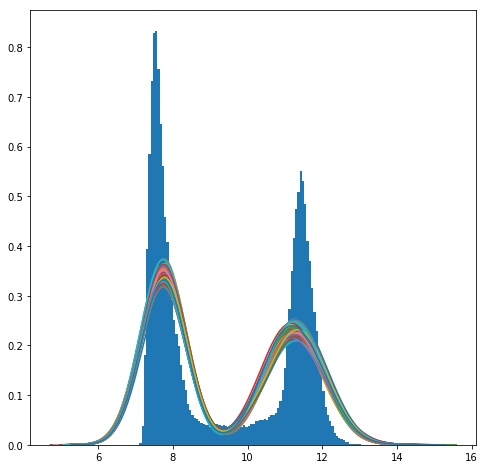

In [201]:
fig = plt.figure(figsize=(8, 8))

plt.hist(dists_list, density=True, bins=100);
for mix in mixtures:
    sampled = np.array([mix.sample()[0] for _ in range(1000)])
    sns.distplot(sampled[:, 0, 0], hist=False)

We expect that two state behavior could describe out data. However the fit is rather poor. It is because of assymetric tails of left and right parts of distributions. Let's fit 3-component gaussian mixture.

In [204]:
mixtures = []

for _ in tqdm(range(100)):
    mix = GaussianMixture(3)
    mix.fit(np.array(dists_list)[:, None])
    mixtures.append(mix)

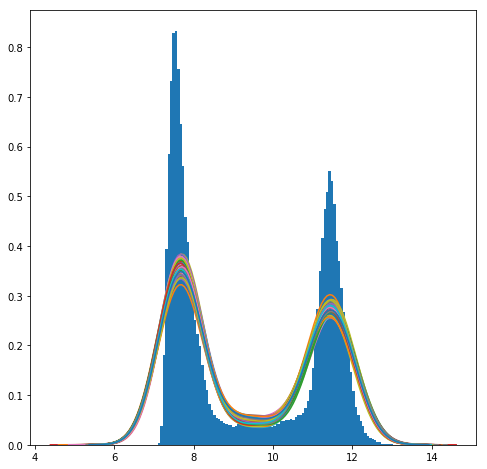

In [205]:
fig = plt.figure(figsize=(8, 8))

plt.hist(dists_list, density=True, bins=100);
for mix in mixtures:
    sampled = np.array([mix.sample()[0] for _ in range(1000)])
    sns.distplot(sampled[:, 0, 0], hist=False)

Still far from ideal fit, but looks reasonable. Further increase in components barely changes the fit.

In [207]:
mixtures = []

for _ in tqdm(range(100)):
    mix = GaussianMixture(4)
    mix.fit(np.array(dists_list)[:, None])
    mixtures.append(mix)

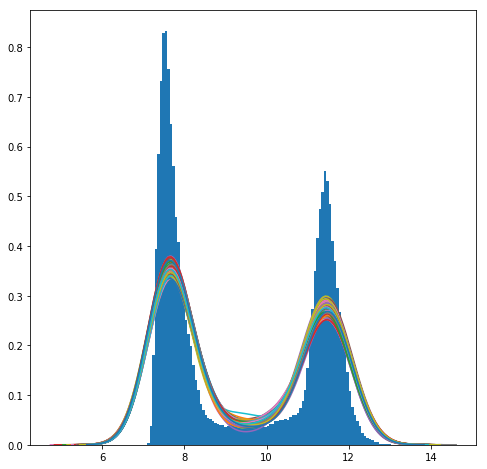

In [208]:
fig = plt.figure(figsize=(8, 8))

plt.hist(dists_list, density=True, bins=100);
for mix in mixtures:
    sampled = np.array([mix.sample()[0] for _ in range(1000)])
    sns.distplot(sampled[:, 0, 0], hist=False)

$$
P (class=c\ |\ X=x) = \frac{P(X=x\ |\ class=c) P (class=c)}{\sum_{i}P(X=x | class=i)}
$$

There are three states: `associated` (A), `intermediate` (I) and `disassociated` (D). We want to find boundaries between them. Let's find points where probability of A = probability of I.

$$
P(class = A\ |\ X=x) = P(class = I\ |\ X=x)
$$

$$
\frac{P(X=x\ |\ class=A) P (class=A)}{\sum_{i}P(X=x | class=i)} = \frac{P(X=x\ |\ class=I) P (class=I)}{\sum_{i}P(X=x | class=i)}
$$

$$
P(X=x\ |\ class=A) P (class=A) = P(X=x\ |\ class=I) P (class=I)
$$

As long as both distributions are gaussian.

$$
\frac{1}{\sqrt{2 \pi}\sigma_{A}} \exp{\frac{-(x-\mu_{A})^2}{2\sigma_{A}^2}} = \frac{1}{\sqrt{2 \pi}\sigma_{I}} \exp{\frac{-(x-\mu_{I})^2}{2\sigma_{I}^2}}
$$

$$
\frac{1}{\sigma_{A}} \exp{\frac{-(x-\mu_{A})^2}{2\sigma_{A}^2}} = \frac{1}{\sigma_{I}} \exp{\frac{-(x-\mu_{I})^2}{2\sigma_{I}^2}}
$$

$$
-\ln{\sigma_{A}} + \frac{-(x-\mu_{A})^2}{2\sigma_{A}^2} = -\ln{\sigma_{I}} + \frac{-(x-\mu_{I})^2}{2\sigma_{I}^2}
$$

Use solver (like Wolframalpha) to get solution 

$$
x_{A \to I} = -\frac{\sqrt{\sigma_{A}^2 \sigma_{I}^2 (2(\sigma_{A}^2 - \sigma_{I}^2)ln(\sigma_{A}) - 2(\sigma_{A}^2 - \sigma_{I}^2)\ln(\sigma_{I})+(\mu_{A} - \mu_{I})^2)} - \sigma_{A}^2\mu_{I} + \sigma_{I}^2\mu_{A}}{\sigma_{A}^2 - \sigma_{I}^2}
$$

$$
x_{I \to D} = -\frac{\sqrt{\sigma_{I}^2 \sigma_{D}^2 (2(\sigma_{I}^2 - \sigma_{D}^2)ln(\sigma_{I}) - 2(\sigma_{I}^2 - \sigma_{D}^2)\ln(\sigma_{D})+(\mu_{I} - \mu_{D})^2)} - \sigma_{I}^2\mu_{D} + \sigma_{D}^2\mu_{I}}{\sigma_{I}^2 - \sigma_{D}^2}
$$

In [647]:
means = mix.means_[:, 0]
idx = np.argsort(means)
means = means[idx]
apriori = mix.weights_[idx]
stds = 1 / np.sqrt(mix.precisions_[idx, 0, 0])

In [660]:
def norm_pdf(x, mean=0., std=1.):
    return scipy.stats.norm().pdf((x - mean) / std)

def classify_(x, mix):
    assert x >= 7 and x <= 12.5
    means = mix.means_[:, 0]
    idx = np.argsort(means)
    means = means[idx]
    apriori = mix.weights_[idx]
    stds = 1 / np.sqrt(mix.precisions_[idx, 0, 0])
    
    aposteriori = np.zeros_like(apriori)
    full_probability = sum([norm_pdf(x, means[c], stds[c]) for c in range(len(apriori))])
    
    for c in range(len(apriori)):
        aposteriori[c] = norm_pdf(x, means[c], stds[c]) * apriori[c] / full_probability

    return aposteriori

final_mixtures = []

A_to_I = np.zeros(100)
I_to_D = np.zeros(100)

for i in tqdm(range(100)):
    mix = GaussianMixture(3)
    mix.fit(np.array(dists_list)[:, None])
    final_mixtures.append(mix)
    
    means = mix.means_[:, 0]
    idx = np.argsort(means)
    means = means[idx]
    apriori = mix.weights_[idx]
    stds = 1 / np.sqrt(mix.precisions_[idx, 0, 0])
    
    s_A, s_I, s_D = stds**2
    m_A, m_I, m_D = means

    s_diff_1 = (s_A - s_I)
    s_diff_2 = (s_I - s_D)
    m_diff_1 = (m_A - m_I) ** 2
    m_diff_2 = (m_I - m_D) ** 2

    A_to_I[i] = -(np.sqrt(s_A*s_I*(s_diff_1 * np.log(s_A / s_I) + m_diff_1 )) - s_A*m_I + s_I*m_A) / s_diff_1
    I_to_D[i] = -(np.sqrt(s_I*s_D*(s_diff_2 * np.log(s_I / s_D) + m_diff_2 )) - s_I*m_D + s_D*m_I) / s_diff_2
    
a_to_i = np.mean(A_to_I)
i_to_d = np.mean(I_to_D)
    
def classify(x_arr):
    result = np.zeros_like(x_arr, dtype=np.uint8)
    result[x_arr < a_to_i] = 0
    result[(x_arr >= a_to_i) & (x_arr < i_to_d)] = 1
    result[x_arr >= i_to_d] = 2
    return result

# Smooth maximum distance

In [790]:
WINDOW=1
def moving_average(x, window=WINDOW):
    return (np.cumsum(x)[window:] - np.cumsum(x)[:-window]) / window

In [677]:
dist_arr = np.array([v for v in dist_dict.values()])

In [791]:
dist_arr_smooth = np.zeros((21, 10, 1000 - WINDOW))

for f in range(21):
    for r in range(10):
        dist_arr_smooth[f, r] = moving_average(dist_arr[f, r])

In [792]:
classified = classify(dist_arr_smooth)

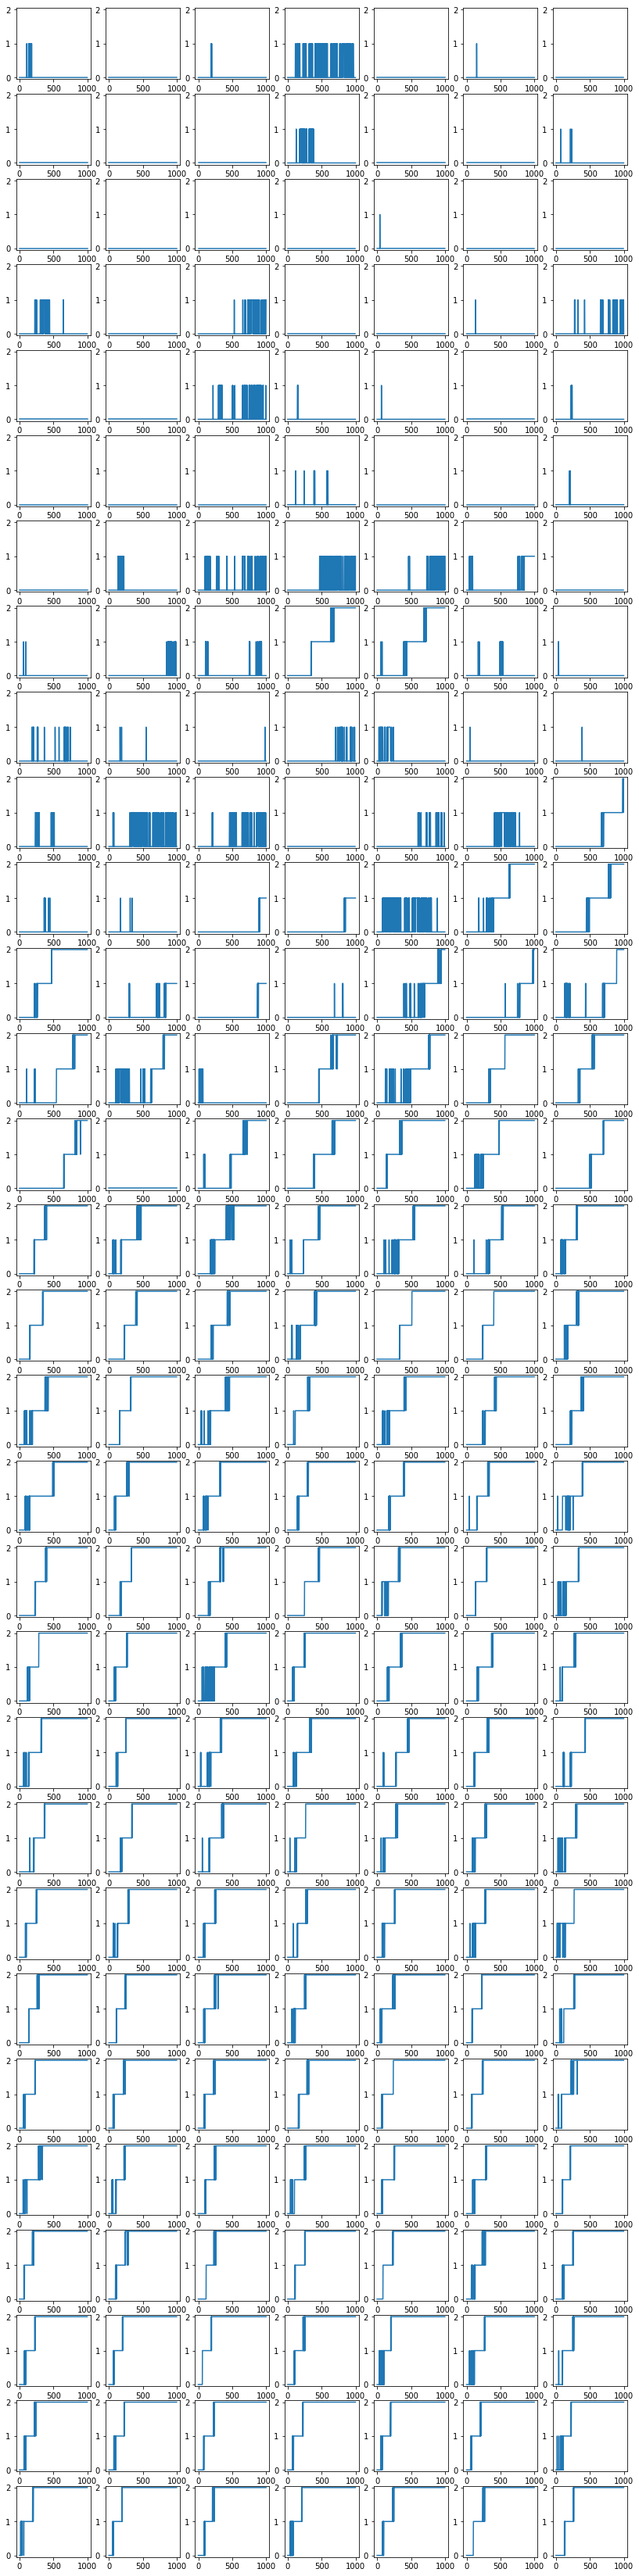

In [793]:
fig = plt.figure(figsize=(14, 60))

for f in range(21):
    for r in range(10):
        ax = fig.add_subplot(30, 7, f * 10 + r + 1)
        ax.plot(classified[f, r, :])
        ax.set_ylim(-0.05, 2.05)

In [794]:
classified.shape

(21, 10, 999)

In [822]:
I_to_D_frames = []

for force in range(21):
    for rep in range(10):
        convolved = scipy.signal.convolve(classified[force, rep], np.array([1, 2])) == 5
        I_to_D_frames.extend([(rep, force, i) for i in np.where(convolved)[0]])

In [820]:
I_to_A_frames = []

for force in range(21):
    for rep in range(10):
        convolved = scipy.signal.convolve(classified[force, rep], np.array([1, -1])) == 1
        I_to_A_frames.extend([(rep, force, i) for i in np.where(convolved)[0]])

In [832]:
I_to_A_dists = whole_arr[list(zip(*I_to_A_frames))]
I_to_A_contacts = I_to_A_dists <= 4.5

I_to_D_dists = whole_arr[list(zip(*I_to_D_frames))]
I_to_D_contacts = I_to_D_dists <= 4.5

(0, 50000)

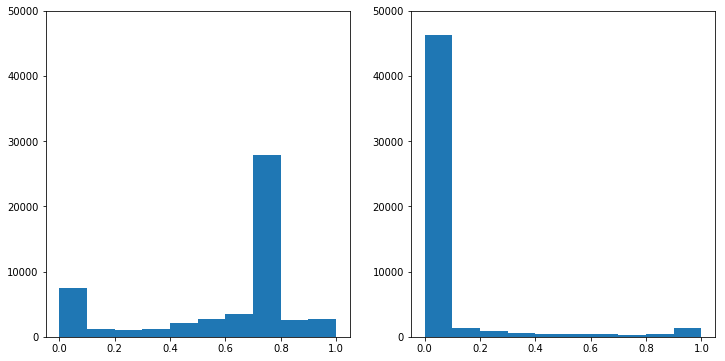

In [837]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.hist(I_to_A_contacts.mean(axis=0))
ax.set_ylim(0, 50000)

ax = fig.add_subplot(1, 2, 2)
ax.hist(I_to_D_contacts.mean(axis=0))
ax.set_ylim(0, 50000)

We can clearly see that there are lots of long-living contacts in I to A transitions and almost no contacts in I to D transitions (that's not a surprise, huh?)  

In [881]:
diff_matrix = I_to_A_contacts.mean(axis=0) - I_to_D_contacts.mean(axis=0)

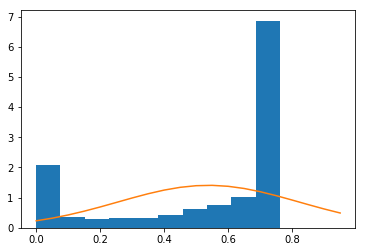

In [882]:
mix = GaussianMixture()
plt.hist(diff_matrix, density=True)
mix.fit(diff_matrix[:, None])

xs_ = np.arange(0, 1, 0.05)
xs = xs_ - mix.means_[0, 0]
xs *= np.sqrt(mix.precisions_[0, 0, 0])
ys = np.sqrt(mix.precisions_[0, 0, 0]) * scipy.stats.norm().pdf(xs) 

plt.plot(xs_, ys)

That doesn't look like normal distribution :)  
Let's try to fit diff of mean distances

In [883]:
diff_matrix = I_to_A_dists.mean(axis=0) - I_to_D_dists.mean(axis=0)

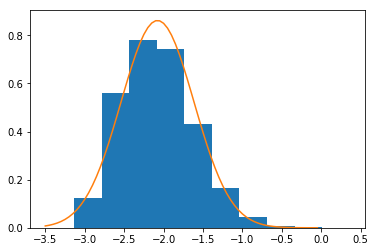

In [884]:
mix = GaussianMixture()
plt.hist(diff_matrix, density=True)
mix.fit(diff_matrix[:, None])
std = 1 / np.sqrt(mix.precisions_[0, 0, 0])
mean = mix.means_[0, 0]

xs_ = np.arange(-3.5, 0, 0.05)
xs = xs_ - mean
xs /= std
ys = 1 / std * scipy.stats.norm().pdf(xs) 

plt.plot(xs_, ys)

In [865]:
mean + 2 * std

-1.1511142415037132

In [866]:
mean - 2 * std

-3.0029560531289339

In [885]:
np.where(diff_matrix <= (mean - 2.25 * std))

(array([30967, 31363, 35719, 35917, 36115, 45619]),)

In [868]:
diff_matrix.shape

(52470,)

In [869]:
scipy.stats.normaltest(diff_matrix)

NormaltestResult(statistic=1500.6199655501905, pvalue=0.0)

In [693]:
forces_D, reps_D, frames_D = np.where(classified == 2)
forces_I, reps_I, frames_I = np.where(classified == 1)
forces_A, reps_A, frames_A = np.where(classified == 0)

In [691]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz")["arr_0"]

In [766]:
D_arr = whole_arr[reps_D, forces_D, frames_D]
I_arr = whole_arr[reps_I, forces_I, frames_I]
A_arr = whole_arr[reps_A, forces_A, frames_A]

In [695]:
D_arr.shape

(82604, 52470)

In [696]:
A_arr.shape

(95443, 52470)

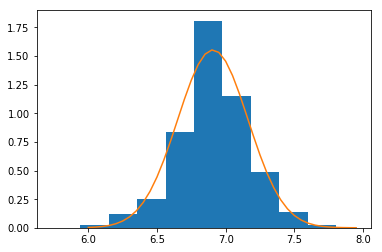

In [757]:
D_arr_mean = D_arr.mean(axis=1)
_mix = GaussianMixture()
_mix.fit(D_arr_mean[:, None])

plt.hist(D_arr_mean, density=True)

xs_ = np.arange(6, 8, 0.05)
xs = xs_ - _mix.means_[0, 0]
xs *= np.sqrt(_mix.precisions_[0, 0, 0])
ys = np.sqrt(_mix.precisions_[0, 0, 0]) * scipy.stats.norm().pdf(xs) 

plt.plot(xs_, ys)

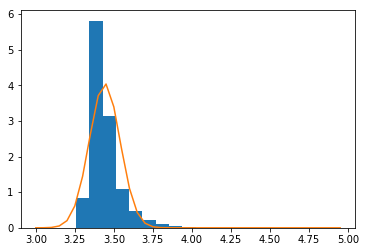

In [764]:
A_arr_mean = A_arr.mean(axis=1)
_mix = GaussianMixture()
_mix.fit(A_arr_mean[:, None])

plt.hist(A_arr_mean, density=True)

xs_ = np.arange(3, 5, 0.05)
xs = xs_ - _mix.means_[0, 0]
xs *= np.sqrt(_mix.precisions_[0, 0, 0])
ys = np.sqrt(_mix.precisions_[0, 0, 0]) * scipy.stats.norm().pdf(xs) 

plt.plot(xs_, ys)

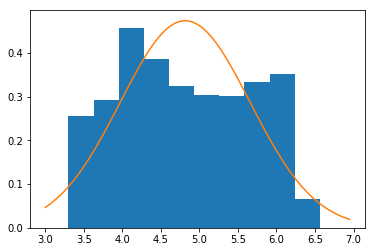

In [768]:
I_arr_mean = I_arr.mean(axis=1)
_mix = GaussianMixture()
_mix.fit(I_arr_mean[:, None])

plt.hist(I_arr_mean, density=True)

xs_ = np.arange(3, 7, 0.05)
xs = xs_ - _mix.means_[0, 0]
xs *= np.sqrt(_mix.precisions_[0, 0, 0])
ys = np.sqrt(_mix.precisions_[0, 0, 0]) * scipy.stats.norm().pdf(xs) 

plt.plot(xs_, ys)

In [777]:
D_contacts_freq = (D_arr <= 3.5).mean(axis=0)
I_contacts_freq = (I_arr <= 3.5).mean(axis=0)
A_contacts_freq = (A_arr <= 3.5).mean(axis=0)

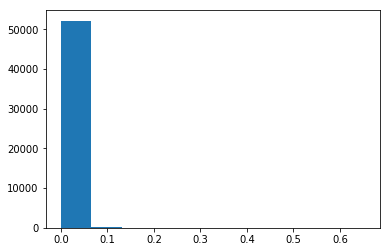

In [775]:
plt.hist(D_contacts_freq);

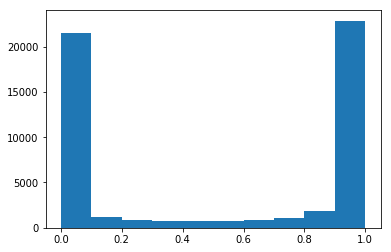

In [776]:
plt.hist(A_contacts_freq);

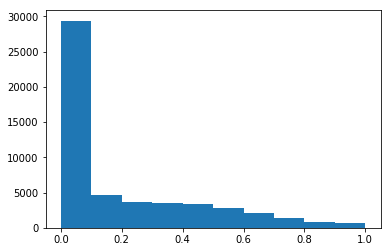

In [778]:
plt.hist(I_contacts_freq);